# Field Analysis


In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.constants import c, e
# h in eV
import scipy
h = scipy.constants.value('Planck constant in eV/Hz')

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from genesis import Genesis4

# Create field data

In [3]:
%%time
G = Genesis4('data/basic4/cu_hxr.in')
G.input['main'][1]['sample'] = 20
G.input['main'][6]['zstop'] = 60
G.input['main'].append({'type':'write', 'field':'end'})
G.nproc = 8
G.run()

CPU times: user 40.1 ms, sys: 314 ms, total: 354 ms
Wall time: 15min 49s


In [4]:
G.plot('field_energy', y2=['field_xsize', 'field_ysize'], ylim2 =[0, 100e-6])

In [5]:
G.verbose=True
G.load_fields()

Loaded field data: end


# 3D Field data

The full field data is stored as a 3D array of complex numbers `DFL` in units of `sqrt(W)`. The relation of this and the electric field `E` in V/m is
`E = DFL * sqrt(2*Z0) / Δ`, where `Z0 = π * 119.9169832 V^2/W` exactly and `Δ` is the grid spacing. 

In [6]:
DFL = G.field['end']['dfl'] # sqrt(W)

DFL.dtype, DFL.shape

(dtype('complex128'), (101, 101, 5440))

In [7]:
param = G.field['end']['param']

param

{'gridpoints': 101,
 'gridsize': 2e-06,
 'refposition': 0.0,
 'wavelength': 1.3789244869952112e-10,
 'slicecount': 5440,
 'slicespacing': 2.7578489739904224e-09}

Gather some convenient variables and arrays:

In [8]:
Ns = param['slicecount']
ds = param['slicespacing']
λ0 = param['wavelength']
f0 = c / λ0
dt = ds / c 
Δ = param['gridsize']

s = np.arange(0, Ns) * ds
t = -s/c

# Field power

The power array sums over the x and y components of the absolute square of the field data.

In [9]:
power0 = G.output['Field/power'][-1,:] # W

In [10]:
power1 = np.sum(np.sum(np.abs(DFL)**2, axis = 0), axis=0) # W

These are the same:

In [11]:
np.allclose(power0, power1)

True

Text(0, 0.5, 'power (GW)')

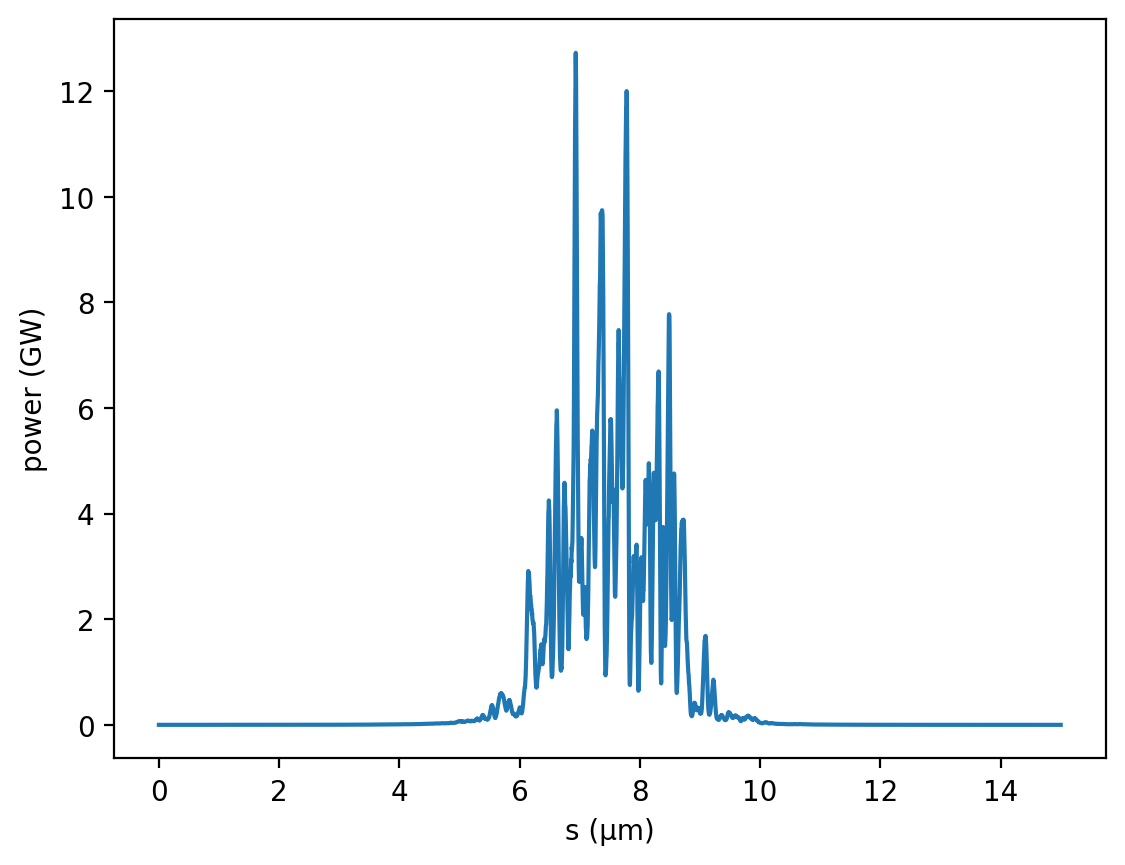

In [13]:
fig, ax = plt.subplots()
ax.plot(s * 1e6, power0 /1e9)
ax.set_xlabel('s (µm)')
ax.set_ylabel('power (GW)')

# Field energy

The total field energy is the integral:

In [14]:
energy1 = np.trapz(power1, dx = dt)

energy1 # J

3.4988313433626924e-05

In [16]:
np.sum(power1)*dt # J

3.498831343912882e-05

# On-axis field intensity and phase

In [17]:
intensity0 = G.output['Field/intensity-nearfield'][-1,:] # W/m^2
phase0 = G.output['Field/phase-nearfield'][-1,:] # radian

In [18]:
icenter = param['gridpoints']//2
field1= DFL[icenter, icenter, :]  # sqrt(W)
phase1 = np.angle(field1) # radian

intensity1 = np.abs(field1**2)/ Δ**2 # W/m^2

These are the same:

In [19]:
np.allclose(intensity0, intensity1)

True

In [20]:
np.allclose(phase0, phase1)

True

In [21]:
fig, ax = plt.subplots()
ax.plot(s * 1e6, intensity0)
ax.set_xlabel('s (µm)')
ax.set_ylabel(r'intensity (W/m$^2$)')

Text(0, 0.5, 'intensity (W/m$^2$)')

The same field can be reconstructed from these arrays

In [22]:
field0 = np.sqrt(intensity0) * np.exp(1j * phase0) * Δ # sqrt(W)

These are the same:

In [23]:
np.allclose(field0, field1)

True

# Spectrum

The spectrum calculation takes some care with the FFT and units.

TODO: Verify this!

In [24]:
def FFT(array):
    return np.fft.fftshift(np.fft.fft(array))

def spectrum_from(field, dt):
    spectrum = FFT(field * dt)
    freqs = np.fft.fftshift(np.fft.fftfreq(Ns, dt))

    return freqs, spectrum

In [25]:
freqs, spectrum = spectrum_from(field0, dt)

# Frequency spacing
df = np.diff(freqs)[0] # Hz

Check Plancherel theorem

In [26]:
np.sum(np.abs(field0)**2) * dt # J 

1.173958808212307e-07

In [27]:
np.sum(np.abs(spectrum)**2) * df # J 

1.1739588082120118e-07

Text(0, 0.5, 'spectral fluence (J/m$^2$/eV)')

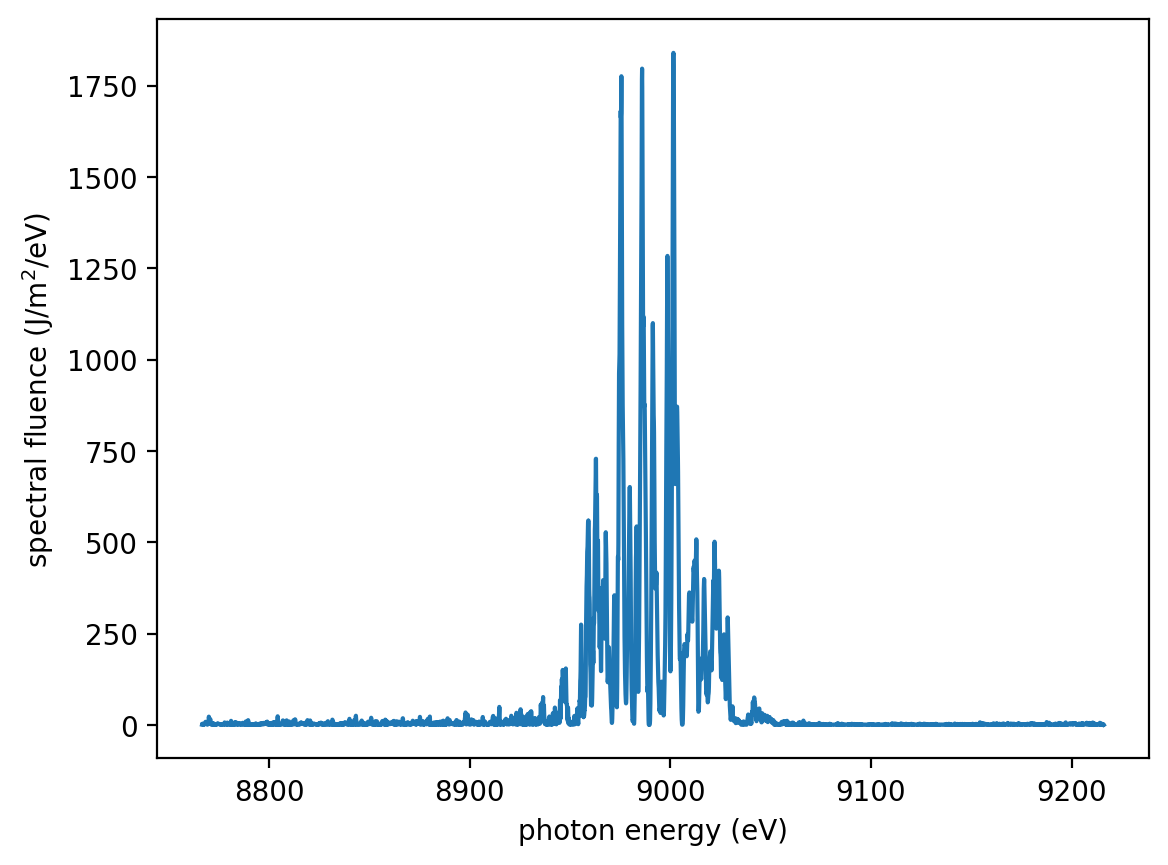

In [28]:
fig, ax = plt.subplots()

photon_energies = h*(freqs + f0) # eV
spectral_fluence =  np.abs(spectrum**2) / Δ**2 / h # J/m^2/eV

ax.plot(photon_energies, spectral_fluence)
ax.set_xlabel('photon energy (eV)')
ax.set_ylabel(r'spectral fluence (J/m$^2$/eV)')

Text(0, 0.5, 'spectral intensity (photons/mm$^2$/eV)')

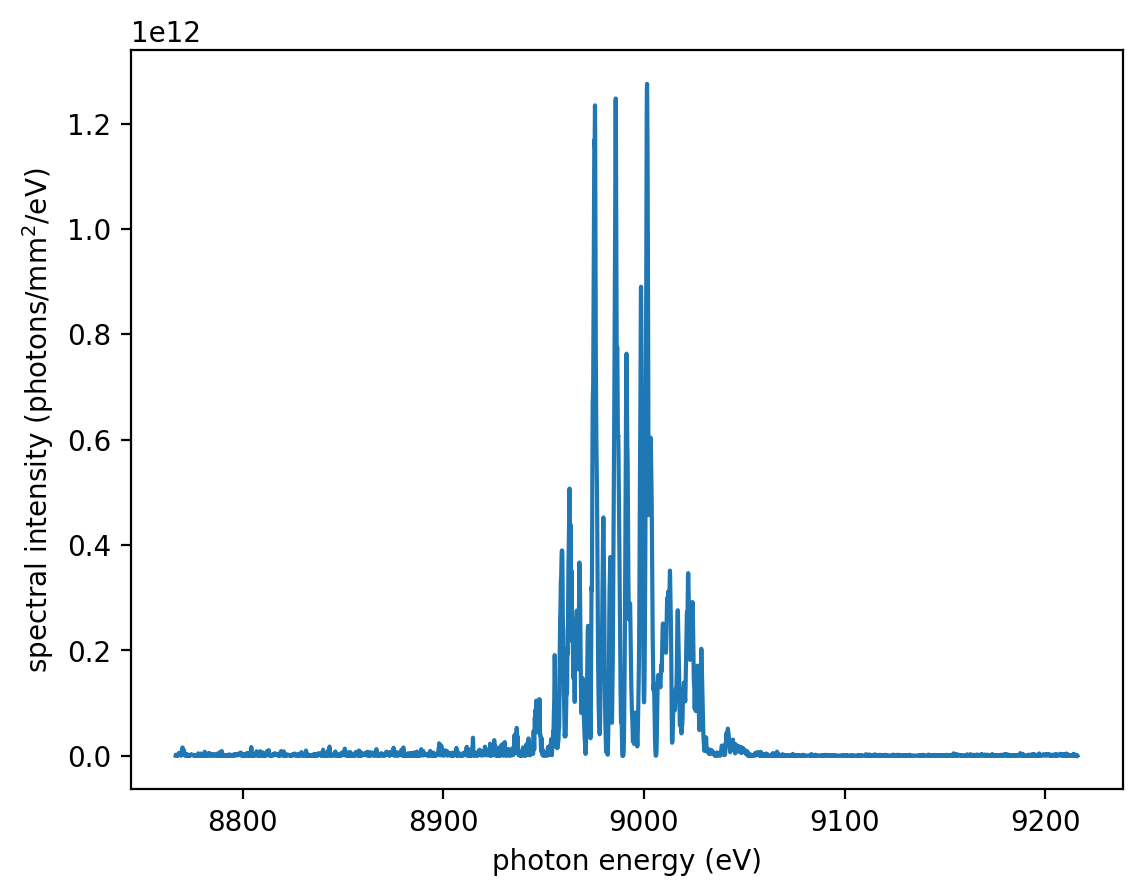

In [29]:
fig, ax = plt.subplots()
J_per_photon = (h*(freqs + f0)*e) # note h is in eV/Hz
ax.plot(photon_energies, spectral_fluence / J_per_photon  * 1e-6)
ax.set_xlabel('photon energy (eV)')
ax.set_ylabel(r'spectral intensity (photons/mm$^2$/eV)')

# Field data formats

Genesis4 writes a custom field format. LUME-Genesis provides a reader for this, as well as a conversion tool to write in the [openPMD-wavefront standard](https://github.com/openPMD/openPMD-standard/blob/upcoming-2.0.0/EXT_Wavefront.md).

## Read Field h5

In [30]:
from genesis.version4 import readers
import h5py

In [31]:
FILE = G.output['field_files'][0]
FILE

'/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpyldlir60/end.fld.h5'

In [32]:
h5py.is_hdf5(FILE)

True

In [33]:
with h5py.File(FILE, 'r') as h5:
    DFL, PARAM = readers.load_genesis4_fields(h5)

In [34]:
DFL.shape, DFL.dtype, PARAM

((101, 101, 5440),
 dtype('complex128'),
 {'gridpoints': 101,
  'gridsize': 2e-06,
  'refposition': 0.0,
  'wavelength': 1.3789244869952112e-10,
  'slicecount': 5440,
  'slicespacing': 2.7578489739904224e-09})

## Write Wavefront in openPMD-wavefront

In [35]:
from genesis.version4 import writers
import numpy as np

In [36]:
writers.write_openpmd_wavefront('genesis4_wavefront.h5', DFL, PARAM, verbose=True)

Writing wavefront (dfl data) to file genesis4_wavefront.h5


'genesis4_wavefront.h5'

In [37]:

# Read back
with h5py.File('genesis4_wavefront.h5', 'r') as h5:
    print(list(h5['data']['000000']['meshes']))
    
    g = h5['data/000000/meshes/electricField']
    print(dict(g.attrs))
    
    # Get 
    E2 = h5['data/000000/meshes/electricField/x'][:]


['electricField']
{'axisLabels': array(['x', 'y', 'z'], dtype=object), 'geometry': 'cartesian', 'gridGlobalOffset': array([-1.00000000e-04, -1.00000000e-04, -7.50134921e-06]), 'gridSpacing': array([2.00000000e-06, 2.00000000e-06, 2.75784897e-09]), 'gridUnitDimension': array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]]), 'gridUnitSI': array([1., 1., 1.]), 'photonEnergy': 8991.3696944618, 'photonEnergyUnitDimension': array([ 2,  1, -2,  0,  0,  0,  0]), 'photonEnergyUnitSI': 1.602176634e-19, 'timeOffset': 0.0, 'unitDimension': array([ 1,  1, -3, -1,  0,  0,  0])}


In [38]:
# Data is the same
np.all(E2 == DFL)

True

# Plot

Simple plot

In [39]:
# Nicer plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
%config InlineBackend.figure_format = 'retina'

import numpy as np

In [41]:
# Sum over y and compute the absolute square 
dat2 = np.sum(np.abs(DFL)**2, axis=1)

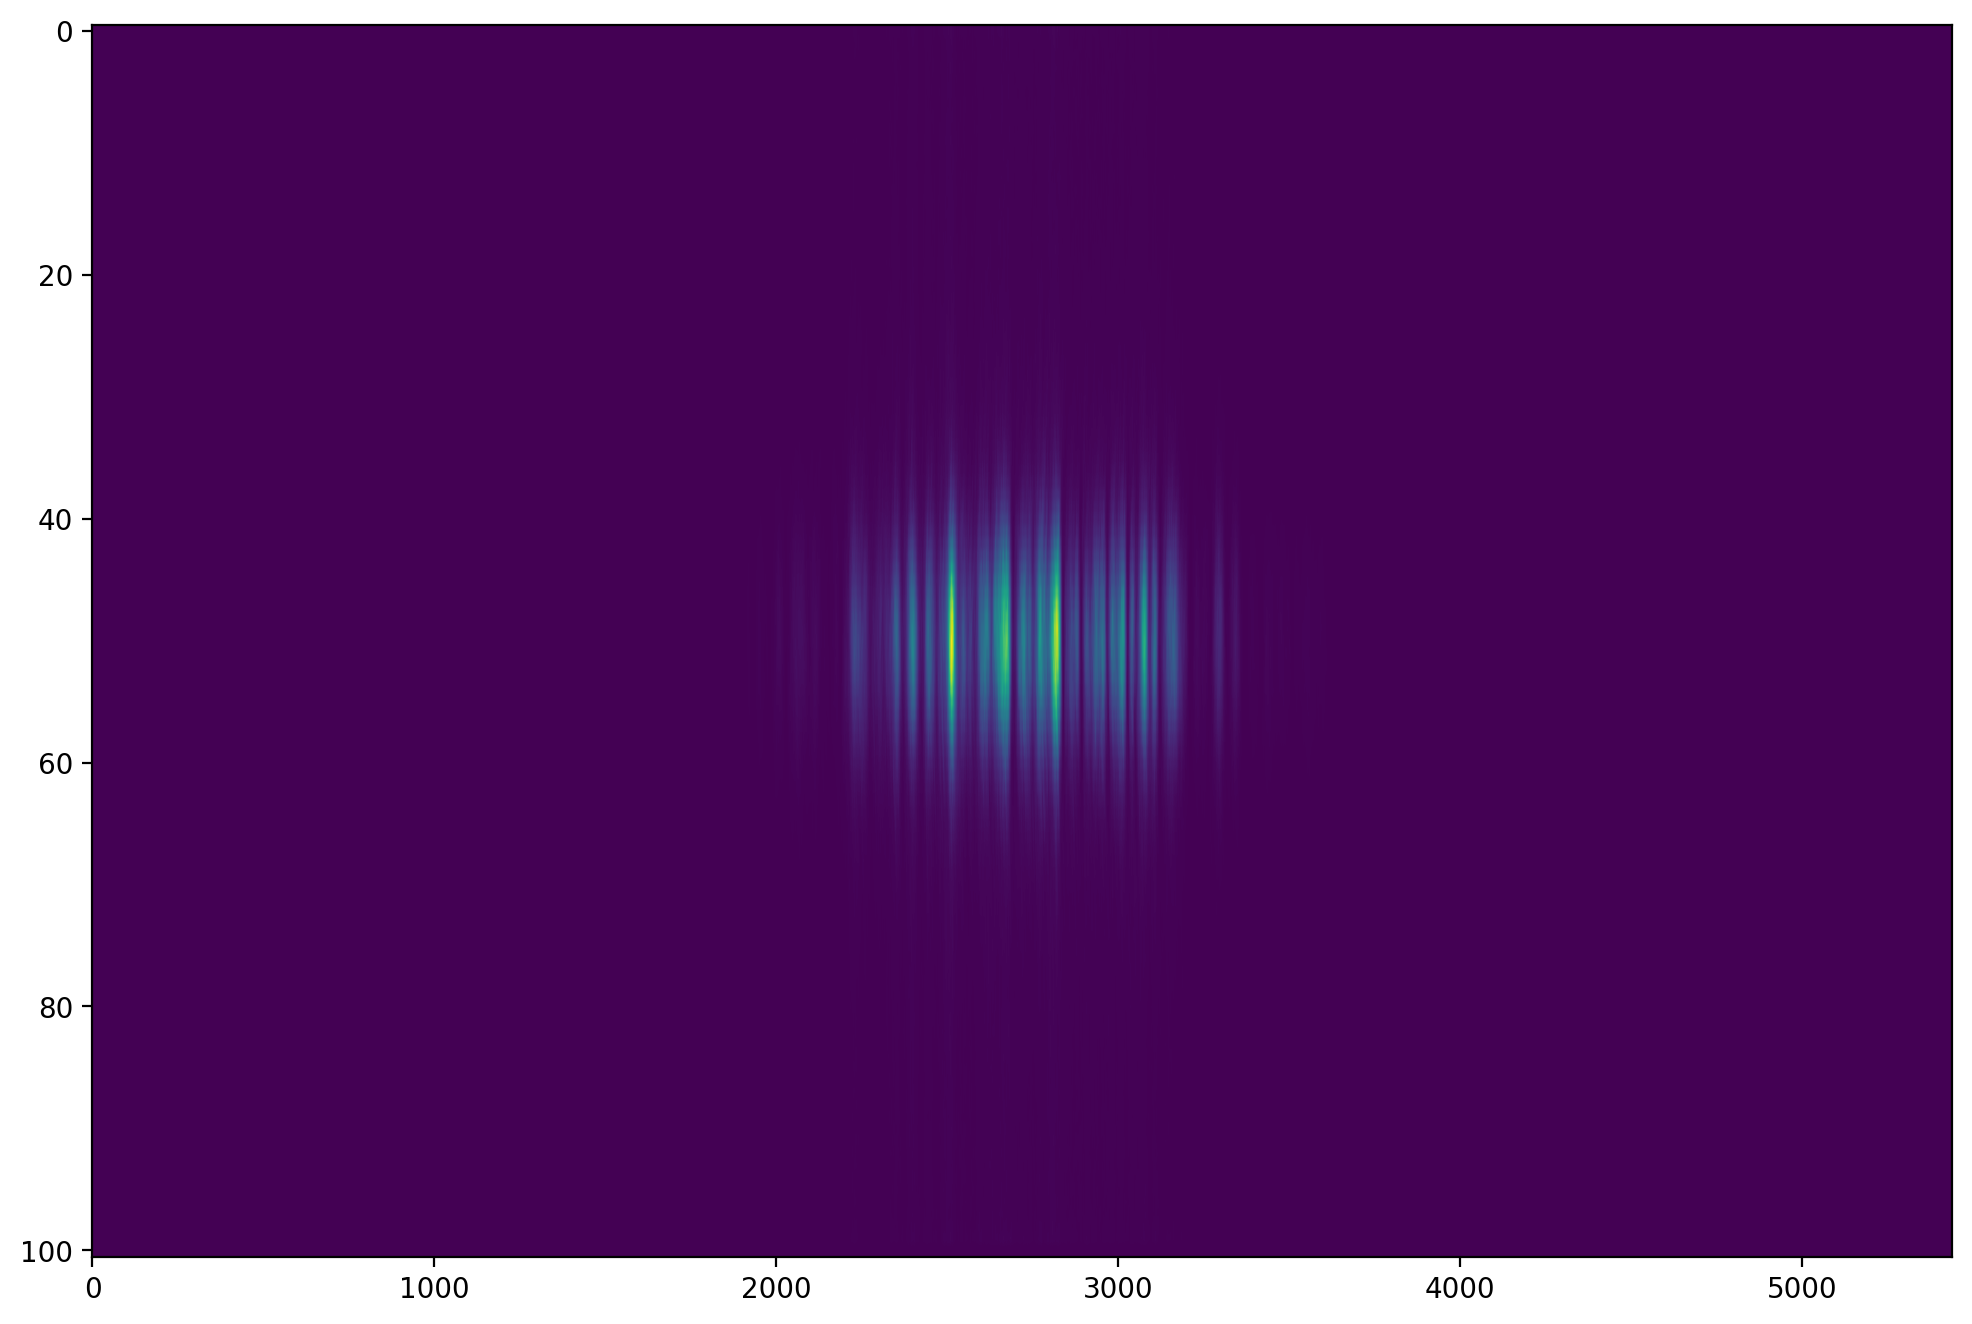

In [42]:
# Plot the center
plt.imshow(dat2[::,:], aspect='auto')

#plt.axis('off');plt.savefig('../../assets/field.png', bbox_inches='tight')

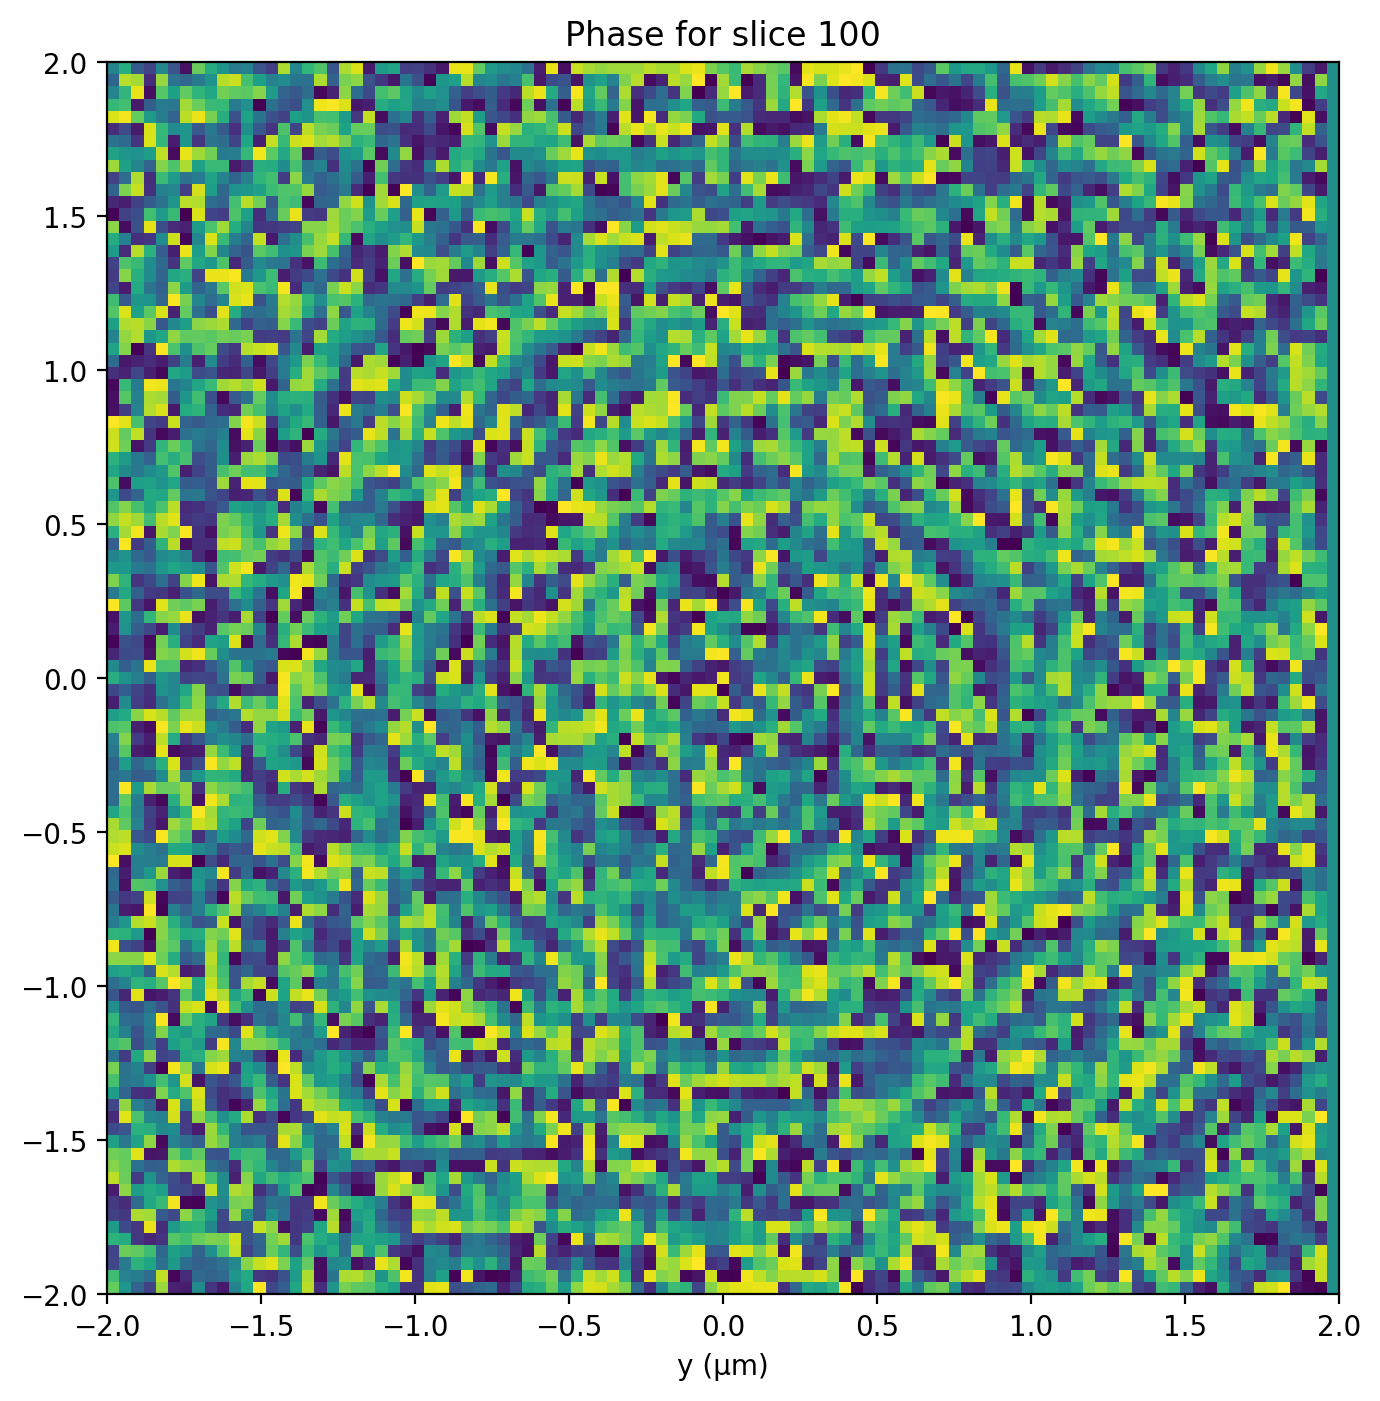

In [43]:
def plot_slice(i=0):
    
    dat = np.angle(DFL[:,:,i])
    
    dx = PARAM['gridsize']*1e6
    plt.xlabel('x (µm)')
    plt.xlabel('y (µm)')
    plt.title(f'Phase for slice {i}')
    plt.imshow(dat.T, origin='lower', extent=[-dx,dx,-dx,dx])
plot_slice(i=100)

In [44]:
from ipywidgets import interact

In [45]:
interact(plot_slice, i=(0,len(DFL[0,0,:])-1, 1))

interactive(children=(IntSlider(value=0, description='i', max=5439), Output()), _dom_classes=('widget-interact…

<function __main__.plot_slice(i=0)>

# Cleanup 

In [46]:
!rm genesis4_wavefront.h5